In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define emotion labels and number of classes
emotions = ['angry', 'fear', 'happy', 'sad', 'surprise']
num_classes = len(emotions)

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset class
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx] if self.labels is not None else None
        if self.transform:
            image = self.transform(image)
        return (image, label) if label is not None else image

# Load dataset
train_dir = 'data/train'
file_names = []
labels = []

for label, emotion in enumerate(emotions):
    emotion_dir = os.path.join(train_dir, emotion)
    for img_file in os.listdir(emotion_dir):
        file_path = os.path.join(emotion_dir, img_file)
        file_names.append(file_path)
        labels.append(label)

# Data augmentations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = EmotionDataset(file_names, labels, transform=transform_train)
train_dl = DataLoader(train_dataset, batch_size=16, shuffle=True)

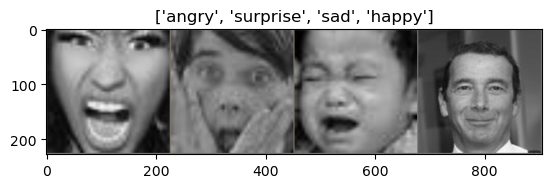

In [2]:
import torchvision


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(DataLoader(train_dataset, batch_size=4, shuffle=True)))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[emotions[x] for x in classes])


In [4]:
from torch.optim.lr_scheduler import StepLR


# Define the ResNet50 model with custom final layer
class ResNet50EmotionModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50EmotionModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

model = ResNet50EmotionModel(num_classes=num_classes).to(device)

# Define optimizer and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
num_epochs = 30  # Number of epochs
train_losses = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_dl:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    train_losses.append(epoch_loss)
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current learning rate: {current_lr:.6f}')

print('Training complete')

torch.save(model.state_dict(), 'resnet50_emotion_model.pth')

Epoch 0/29
----------
Train Loss: 0.8906 Acc: 0.6552
Current learning rate: 0.000100
Epoch 1/29
----------
Train Loss: 0.5886 Acc: 0.7835
Current learning rate: 0.000100
Epoch 2/29
----------
Train Loss: 0.4623 Acc: 0.8300
Current learning rate: 0.000100
Epoch 3/29
----------
Train Loss: 0.3609 Acc: 0.8726
Current learning rate: 0.000100
Epoch 4/29
----------
Train Loss: 0.2809 Acc: 0.9014
Current learning rate: 0.000050
Epoch 5/29
----------
Train Loss: 0.1395 Acc: 0.9551
Current learning rate: 0.000050
Epoch 6/29
----------
Train Loss: 0.0893 Acc: 0.9738
Current learning rate: 0.000050
Epoch 7/29
----------
Train Loss: 0.0668 Acc: 0.9776
Current learning rate: 0.000050
Epoch 8/29
----------
Train Loss: 0.0650 Acc: 0.9806
Current learning rate: 0.000050
Epoch 9/29
----------
Train Loss: 0.0545 Acc: 0.9825
Current learning rate: 0.000025
Epoch 10/29
----------
Train Loss: 0.0307 Acc: 0.9909
Current learning rate: 0.000025
Epoch 11/29
----------
Train Loss: 0.0176 Acc: 0.9959
Current le

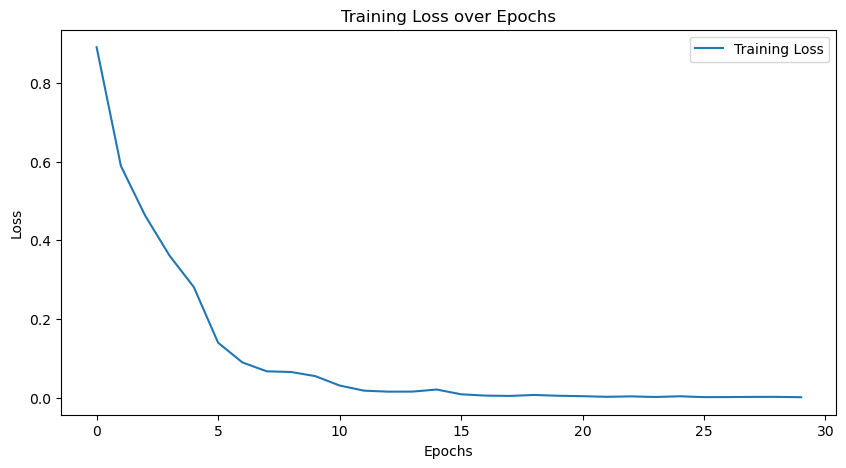

In [5]:
# Plot the training losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [6]:
# Test the model
test_dir = 'data/test'
test_files = [os.path.join(test_dir, img_file) for img_file in os.listdir(test_dir)]
test_dataset = EmotionDataset(test_files, transform=transform_train)  # Reuse train transform
test_dl = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
results = []

for inputs in test_dl:
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()
        results.extend(preds)

results_df = pd.DataFrame({'Id': [os.path.basename(file) for file in test_files], 'emotions': [emotions[pred] for pred in results]})
results_df.to_csv('predictions_resnet50.csv', index=False)

Initial approach - really good -> 84,36% Kaggle Score
- then tested to use no validation data, but 100% training data - resulted in 84,5% Kaggle - yay :)